# What are the effects of different C-Rates on capacity?

## Purpose
[!] This notebook is apart of a series of queries aimed at answering personal questions with supported physics-based models designed to further extend experience, knowledge and application of electrochemsitry across various battery contexts. <br>
For the query outlined: We aim to understand the effects of c-rates on capacity based on research and supporting theories with modeled data.

## Description
In this notebook, we will:
- **Import necessary libraries**: Load essential Python libraries, primarily PyBaMM for supported physics-based analyses.
- **Lay out queries**: Outline questions and procured answers to said questions.
- **Verify against modeled data**: Support various queries with modeled data from PyBaMM.
- **Visualization**: Create visual representations of the results to enhance understanding.

## Author
*Javaid Baksh*  
*Date: January 11, 2025*

## Additional Information
- **Keywords**: -
- **References**: <br>
  - [1] Sullivan, J. (2016). The effects of charge/discharge rate on capacity fade of lithium ion batteries. Ph.D. Thesis.
  - [2] Deng, Y., et al. (2019). Quantifying the factors limiting rate performance in battery electrodes. Nature Communications, 10(1), 1-10.

In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
model = pybamm.lithium_ion.SPMe()
parameter_values = pybamm.ParameterValues("Chen2020")

# Queries
## What are the effects of increasing C-Rate on capacity and why does this occur?

It is a well-known phenomenon that available capacity is decreased with increasing capacity. Examples of this being coneyed can be seen below: <br>
- [1] "The effects of charge/discharge rate on capacity fade of lithium ion batteries. Ph.D. Thesis. This study highlights how higher C-rates lead to accelerated capacity fade due to mechanical degradation of active particles, emphasizing that both chemical and mechanical factors contribute to this decline in capacity." <br>
- [2] "The results indicate that as the C-rate increases, the effective capacity decreases significantly due to limitations in ionic transport within the electrode materials."

Firstly, to support these statements with physuics-based models, let's visualize the available capacity against increasing C-Rates as follows:

In [8]:
C_rates = np.linspace(0.5, 3, 6)  # From 0.05C to 5C
discharging_capacities = np.zeros_like(C_rates)

for i, C_rate in enumerate(C_rates):
    experiment = pybamm.Experiment(
        [
            f"Charge at {C_rate:.2f}C until 4.2V",
            f"Discharge at {C_rate:.2f}C until 3.0V"
        ]
    )
    
    sim = pybamm.Simulation(model, experiment=experiment)
    sim.solve()
    
    time = sim.solution["Time [s]"].entries
    discharge_capacity = sim.solution["Discharge capacity [A.h]"]
    discharging_capacities[i] = discharge_capacity(time[-1])

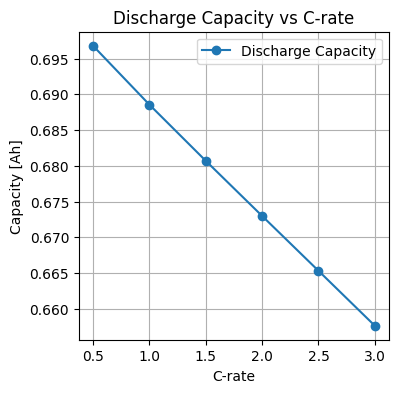

In [9]:
plt.figure(figsize=(4, 4))
plt.plot(C_rates, discharging_capacities, marker='o', label='Discharge Capacity')
plt.title("Discharge Capacity vs C-rate")
plt.xlabel("C-rate")
plt.ylabel("Capacity [Ah]")
plt.grid()
plt.legend()
plt.show()

Evidently, increasing C-Rates reduce available capacity for use. What are the contributing factors to this?
